In [1]:
# Importing all dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import cv2
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.feature_selection import SequentialFeatureSelector as sfs
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# 4: Data pre-processing

In [2]:
# Loading the data
df = pd.read_csv('results.txt')
df.columns = ['id', 'num', 'image', 'label', 'time']
df.drop(["num"], axis=1, inplace=True)

# Removal of outliers
df.drop(df[df['time'] < 0.2].index, inplace=True)
df.drop(df[df['time'] > 3].index, inplace=True)

# Normalization of reaction times for each person
df['mean'] = df.groupby('id')['time'].transform('mean')
df['min'] = df.groupby('id')['time'].transform('min')
df['max'] = df.groupby('id')['time'].transform('max')
df['normalized'] = (df['time']-df['min']) / (2*(df['max'] - df['min']))

df['SmileNorm'] = 1-df['normalized']
df['score'] = df['normalized']
df['score'][df['label'] == "Smiling"] = df['SmileNorm']

df.head()

<ipython-input-2-89816bc61f0b>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'][df['label'] == "Smiling"] = df['SmileNorm']


,id,image,label,time,mean,min,max,normalized,SmileNorm,score
0,7,55_1_0_20170103183939755.jpg.chip.jpg,Smiling,0.7776,0.826893,0.4476,2.2428,0.091912,0.908088,0.908088
1,7,42_1_0_20170105173320357.jpg.chip.jpg,Smiling,0.5956,0.826893,0.4476,2.2428,0.041221,0.958779,0.958779
2,7,26_1_1_20170112205848764.jpg.chip.jpg,Smiling,0.6308,0.826893,0.4476,2.2428,0.051025,0.948975,0.948975
3,7,28_0_3_20170113153014880.jpg.chip.jpg,Not smiling,0.6131,0.826893,0.4476,2.2428,0.046095,0.953905,0.046095
4,7,50_0_0_20170113184603160.jpg.chip.jpg,Not smiling,0.7651,0.826893,0.4476,2.2428,0.088430,0.911570,0.088430


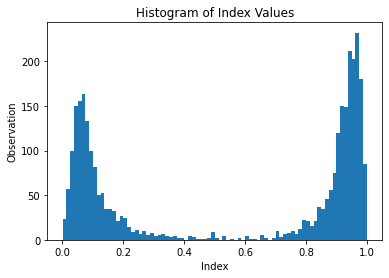

In [3]:
# Plotting histogram of index values
plt.title('Histogram of Index Values')
plt.hist(df['score'], bins = 80)
plt.xlabel('Index')
plt.ylabel('Observation')
plt.savefig('index histogram.png', dpi = 300, bbox_inches='tight')

# 5: PCA and feature selection

In [4]:
# Loading the images
images = [cv2.imread(file) for file in glob.glob("SampledPhotos/*.jpg.chip.jpg")]
image_names = [str(file).split('\\')[1] for file in glob.glob("SampledPhotos/*.jpg.chip.jpg")]
im = np.array(images)

print(f"There are {len(images)} images in our dataset, and the shape of our images are {images[0].shape}")

There are 398 images in our dataset, and the shape of our images are (200, 200, 3)


In [5]:
# Convert images to 1D arrays, and combine all images in one 2D array
big_im = np.zeros([120000,len(images)])
for i in range(len(images)):
    big_im[:,i] = images[i].reshape(120000)

# Get the means of each pixel and subtract mean from every image
means = np.mean(big_im, axis=1)
subtracted_mean = (big_im.T - means).T

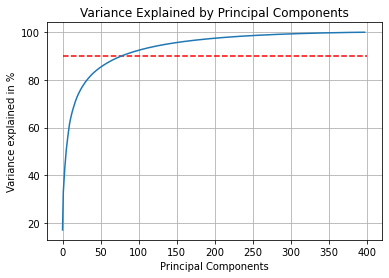

In [6]:
# run pca
pca = PCA()
S = pca.fit_transform(subtracted_mean)

# plot variance of PCA components
variance = pca.explained_variance_ratio_

plt.grid()
plt.plot(np.cumsum(variance)*100)
plt.hlines(90, 0, 400, colors='red', linestyles='dashed')
plt.title('Variance Explained by Principal Components')
plt.ylabel('Variance explained in %')
plt.xlabel('Principal Components')
plt.savefig('Variance explained.png', dpi = 300, bbox_inches='tight')

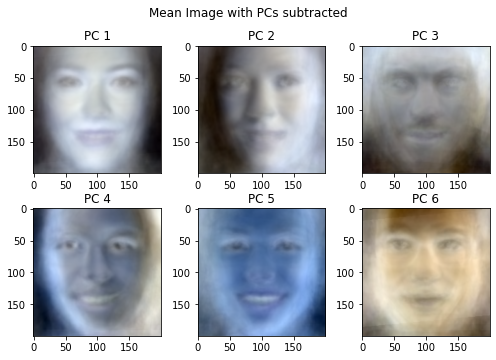

In [77]:
# Convert the components to 200x200x3 image shapes, and plot the first 10
pca_im = S[:,0].reshape([200,200,3])
pca_ims = S.reshape([200,200,3,len(images)])
pca_sub = ((means - S.T).T).reshape([200,200,3,len(images)])
    
fig = plt.figure(figsize=(7,5))
fig.suptitle('Mean Image with PCs subtracted')
columns = 3
rows = 2
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    img = pca_sub[:,:,:,i]
    # We find the max pixel value and divide by that so the image can be better visualized
    img = (img-np.amin(img)) / (np.amax(img)-np.amin(img))
    #img = img / np.amax(img)
    plt.imshow(img)
    plt.title('PC '+str(i+1))
   
plt.tight_layout()
plt.show()
fig.savefig('Scaled PCs2.png', dpi = 650, bbox_inches='tight')

# 6 & 7: Feature Selection and Linear Regression Model

Before we start with the feature selection and linear resression model, we first need to make a new dataframe. This dataframe will contain each image, all the scores for the images, and the average score for each image. We will then use this dataframe, as well as the loaded images from the previous section, to create our X and y data. Finally we split it up into train and test sets using an 80/20 ratio, and then apply PCA on them.

In [8]:
# Create a new dataframe with all the image names
df2 = pd.DataFrame(image_names)
df2.columns = (["image"])

# Add the scores for each person to the dataframe
count = 1
for i in df.groupby("id"):
    grouped_df = i[1][["image","score"]]
    grouped_df.columns = ['image', 'score'+str(count)]
    df2 = pd.merge(df2, grouped_df,how="left", on=["image"])
    count += 1
    
# Take the average score
df2['average'] = df2.mean(numeric_only=True, axis=1)
df2.head()

,image,score1,score2,score3,score4,score5,score6,score7,score8,average
0,20_0_0_20170104230048181.jpg.chip.jpg,0.035245,0.057297,0.078916,0.367870,0.052935,0.083465,0.035031,0.074326,0.098136
1,20_0_1_20170116010734667.jpg.chip.jpg,0.092742,0.839078,0.878550,0.111018,0.943465,NaN,0.884159,0.909813,0.665546
2,20_1_0_20170104021334149.jpg.chip.jpg,0.218306,0.035728,0.043450,0.085339,0.068924,0.082492,0.038197,0.083955,0.082049
3,20_1_0_20170113005610158.jpg.chip.jpg,0.789104,0.865095,0.953187,0.197193,0.908860,0.808310,0.927500,0.118308,0.695945
4,20_1_2_20170108224234471.jpg.chip.jpg,0.885110,0.994107,0.949461,0.919981,0.989179,0.941248,0.946870,0.939748,0.945713


In [9]:
# Train/test split
X = big_im.T
y = df2[['average']].to_numpy()

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)

#scale the training and testing data
pca = PCA()
X_train_pca = pca.fit_transform(scale(X_train))
X_test_pca = pca.transform(scale(X_test))
print('Training dataset shape:', X_train_pca.shape, y_train.shape)
print('Testing dataset shape:', X_test_pca.shape, y_test.shape)

Training dataset shape: (318, 318) (318, 1)
Testing dataset shape: (80, 318) (80, 1)


# 6: Feature Selection

In [10]:
# Cut down to the PCA components which explain 90% of the variance
# This is to make the forward selection slightly faster
threshold = 0.90

for i in range(len(variance)):
    
    if sum(variance[0:i+1]) >= threshold:
        num_features = i + 1
        break

# Extract subset of PC's
print(f"{num_features} features explain 90% of the variance of our dataset")
X_reduced_train = X_train_pca[:,:num_features]
X_reduced_test = X_test_pca[:,:num_features]
print('Reduced training dataset shape:', X_reduced_train.shape, y_train.shape)
print('Reduced testing dataset shape:', X_reduced_test.shape, y_test.shape)

79 features explain 90% of the variance of our dataset
Reduced training dataset shape: (318, 79) (318, 1)
Reduced testing dataset shape: (80, 79) (80, 1)


In [11]:
# Feature selection using sklearn's Sequential Feature Selector
results = []
for i in range(1,50):
    
    # Build RF classifier to use in feature selection
    regr = LinearRegression()
    
    # Build step forward feature selection
    sfs1 = sfs(regr, n_features_to_select=i, direction="forward", cv=5)

    # Perform SFFS
    sfs1 = sfs1.fit(X_reduced_train, y_train)
    regr.fit(X_reduced_train[:,sfs1.get_support()], y_train)

    #calculate RMSE
    pred = regr.predict(X_reduced_test[:,sfs1.get_support()])
    print(f"{i}: {np.sqrt(mean_squared_error(y_test, pred))}")
    results.append(np.sqrt(mean_squared_error(y_test, pred)))

1: 0.3585002620185499
2: 0.33901213667553676
3: 0.30827079163599247
4: 0.2973591449277464
5: 0.2902314390972826
6: 0.2958110874864497
7: 0.2882148845767357
8: 0.29023174770870575
9: 0.291046125593529
10: 0.2791172292349425
11: 0.27423004088403785
12: 0.27267991611870024
13: 0.27084883789596803
14: 0.26394149749693874
15: 0.2691651381254605
16: 0.27136482579075405
17: 0.27146525028922835
18: 0.271304688605507
19: 0.2671894782337976
20: 0.2596702531848665
21: 0.25597997060415817
22: 0.24869506221276702
23: 0.24117379403158307
24: 0.23745273342089654
25: 0.2388255342936118
26: 0.23628446976341075
27: 0.23812963036300383
28: 0.23896929153621735
29: 0.23754064929706004
30: 0.2354312477479958
31: 0.2331321532299189
32: 0.23096977410216135
33: 0.23552581288000227
34: 0.23589884284590237
35: 0.23625177219163998
36: 0.23569925857152668
37: 0.23578131792911838
38: 0.2386635781478659
39: 0.2392887558500821
40: 0.23991667149001872
41: 0.2402356525835667
42: 0.2411156943852166
43: 0.243008795346687

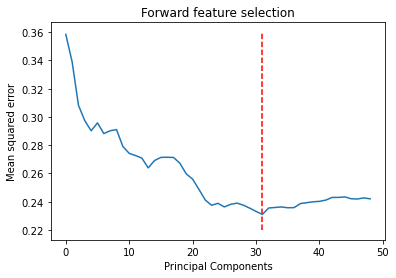

In [12]:
# Plotting the mean squared error of the models against the number of features in the model
plt.plot(results)
plt.title('Forward feature selection')
plt.xlabel('Principal Components')
plt.ylabel('Mean squared error')
plt.vlines(31, 0.22, 0.36, colors = 'r', linestyle = 'dashed')
plt.savefig('Forward selection.png', dpi = 300, bbox_inches='tight')

# 7: Linear Regression Model

From the plot above, we can see that using the mean squared error goes down until around 32 pca components are used, and from then on it stays about the same, even starting to increase again, so we will use 32 pca components for our linear regression model.

In [13]:
# Build step forward feature selection
n = 32
sfs2 = sfs(regr, n_features_to_select=n, direction="forward", cv=5)

# Perform SFFS
sfs2 = sfs2.fit(X_reduced_train, y_train)
#print(sfs1.get_support())

regr.fit(X_reduced_train[:,sfs2.get_support()], y_train)
pred = regr.predict(X_reduced_test[:,sfs2.get_support()])
print(f"The mean squared error for our model with {n} features is {np.sqrt(mean_squared_error(y_test, pred))} \n")

# Show the model's prediction vs real value of the first 10 test pictures
for i in range(10):
    print(f"For picture {i}: predicted {pred[i]} and real answer is {y_test[i]}")

The mean squared error for our model with 32 features is 0.23096977410216135 

For picture 0: predicted [0.46692304] and real answer is [0.96310588]
For picture 1: predicted [0.44573914] and real answer is [0.4003425]
For picture 2: predicted [0.91796374] and real answer is [0.92071789]
For picture 3: predicted [1.01291157] and real answer is [0.92613389]
For picture 4: predicted [0.84421752] and real answer is [0.94844121]
For picture 5: predicted [0.32352483] and real answer is [0.50679443]
For picture 6: predicted [0.4049642] and real answer is [0.32652145]
For picture 7: predicted [0.84606394] and real answer is [0.9533617]
For picture 8: predicted [0.80274562] and real answer is [0.93422207]
For picture 9: predicted [0.22827359] and real answer is [0.47397688]


In [14]:

"""
# Linear model hvor vi bruger alle PCA fra første feature selection

#scale the training and testing data
pca = PCA(n_components = num_features)
X_reduced_train = pca.fit_transform(scale(X_train))
X_reduced_test = pca.transform(scale(X_test))[:,:num_features]
print('Training dataset shape:', X_reduced_train.shape, y_train.shape)
print('Testing dataset shape:', X_reduced_test.shape, y_test.shape)

#train PCR model on training data 
regr = LinearRegression()
regr.fit(X_reduced_train[:,:num_features], y_train)

#calculate RMSE
pred = regr.predict(X_reduced_test)
np.sqrt(mean_squared_error(y_test, pred))

"""

"\n# Linear model hvor vi bruger alle PCA fra første feature selection\n\n#scale the training and testing data\npca = PCA(n_components = num_features)\nX_reduced_train = pca.fit_transform(scale(X_train))\nX_reduced_test = pca.transform(scale(X_test))[:,:num_features]\nprint('Training dataset shape:', X_reduced_train.shape, y_train.shape)\nprint('Testing dataset shape:', X_reduced_test.shape, y_test.shape)\n\n#train PCR model on training data \nregr = LinearRegression()\nregr.fit(X_reduced_train[:,:num_features], y_train)\n\n#calculate RMSE\npred = regr.predict(X_reduced_test)\nnp.sqrt(mean_squared_error(y_test, pred))\n\n"

# 8: Generate samples

In [15]:
S2 = pca.fit_transform(X_train.T)[:,:num_features]
S2.shape

(120000, 79)

In [16]:
xs = []
for i in np.arange(-0.25,1.5,0.25):
    alpha = (i - np.sum(regr.intercept_)) / np.sum(abs(regr.coef_))
    x = alpha*regr.coef_
    xs.append(x)

In [47]:
from PIL import Image
import scipy.misc

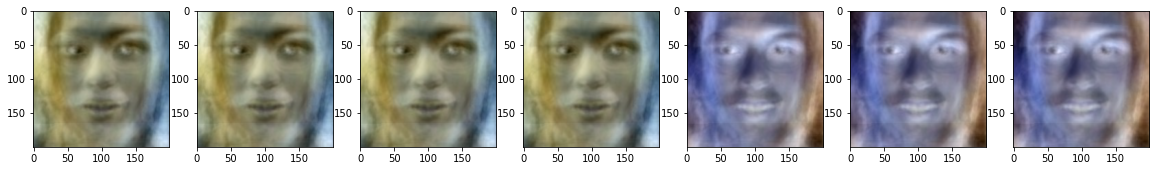

In [78]:
fig = plt.figure(figsize=(20,10))
columns = 7
rows = 1
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    img = (xs[i] @ S2[:,sfs2.get_support()].T).reshape([200,200,3])
    #img = img/np.amax(img)
    img = (img-np.amin(img)) / (np.amax(img)-np.amin(img))
    plt.imshow(img)
plt.show()

# 9 Constructing continuum without reaction times

Text(0.5, 1.0, 'Mean smile')

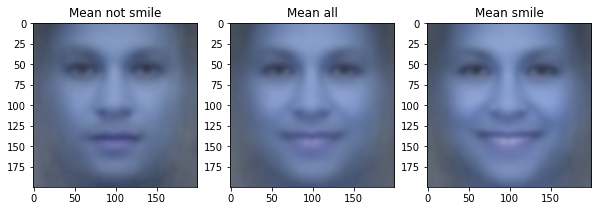

In [26]:
#Generating continuum of faces based on only the pixel-values
score_matrix = np.hstack((X,y))

# Dividing into the two classes based on score
score_matrix_smile = score_matrix[score_matrix[:,-1] > 0.5]
score_matrix_not_smile = score_matrix[score_matrix[:,-1] <= 0.5]

# Removing the last columns containing the scores 
score_matrix_smile_new = np.delete(score_matrix_smile,-1,1)
score_matrix_not_smile_new = np.delete(score_matrix_not_smile,-1,1)
score_matrix_new = np.delete(score_matrix,-1,1)

# Finding mean from not smile class
fig = plt.figure(figsize=(10,7))
mean_not_smile = np.mean(score_matrix_not_smile_new,0)
mean_not_smile_img = mean_not_smile.reshape([200,200,3])
plt.subplot(1,3,1)
plt.imshow(mean_not_smile_img/255)
plt.title('Mean not smile')

# Finding overall mean
mean_all = np.mean(score_matrix_new,0)
mean_all_img = mean_all.reshape([200,200,3])
plt.subplot(1,3,2)
plt.imshow(mean_all_img/255)
plt.title('Mean all')

# Finding the mean images from smile class
mean_smile = np.mean(score_matrix_smile_new,0)
mean_smile_img = mean_smile.reshape([200,200,3])
plt.subplot(1,3,3)
plt.imshow(mean_smile_img/255)
plt.title('Mean smile')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Difference')

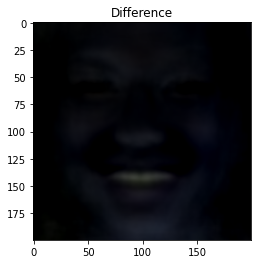

In [19]:
difference = mean_smile - mean_not_smile
difference_img = difference.reshape([200,200,3])
fig = plt.figure(figsize=(5,4))
plt.imshow(difference_img/255)
plt.title('Difference')

Text(0.5, 1.0, 'super smile')

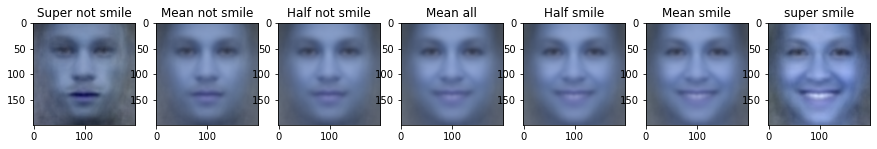

In [90]:
super_not_smile = mean_not_smile - difference
super_not_smile_img = super_not_smile.reshape([200,200,3])
fig = plt.figure(figsize=(15,10))
plt.subplot(1,7,1)
plt.imshow(super_not_smile_img/255)
plt.title('Super not smile')

plt.subplot(1,7,2)
plt.imshow(mean_not_smile_img/255)
plt.title('Mean not smile')

half_not_smile = mean_not_smile + difference/4
half_not_smile_img = half_not_smile.reshape([200,200,3])
plt.subplot(1,7,3)
plt.imshow(half_not_smile_img/255)
plt.title('Half not smile')

plt.subplot(1,7,4)
plt.imshow(mean_all_img/255)
plt.title('Mean all')

half_smile = mean_smile - difference/4
half_smile_img = half_smile.reshape([200,200,3])
plt.subplot(1,7,5)
plt.imshow(half_smile_img/255)
plt.title('Half smile')

plt.subplot(1,7,6)
plt.imshow(mean_smile_img/255)
plt.title('Mean smile')

super_smile = mean_smile + difference
super_smile_img = super_smile.reshape([200,200,3])
plt.subplot(1,7,7)
plt.imshow(super_smile_img/255)
plt.title('super smile')

In [21]:
print(f"From section 6 we know that {num_features} PCA components are required to explain 90% of the variance")

# Create PCA which explains 90% variance
pca_90 = PCA(num_features)
X_pca = pca_90.fit_transform(X)

# Recreate the images using the PCA components
X_proj = pca_90.inverse_transform(X_pca)

From section 6 we know that 79 PCA components are required to explain 90% of the variance


Text(0.5, 1.0, 'super smile')

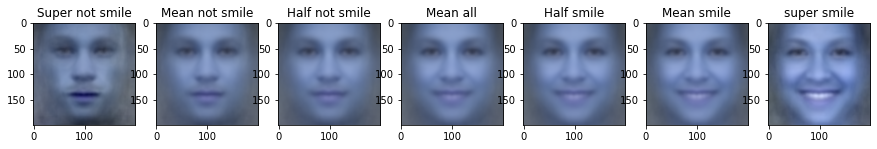

In [91]:
#Generating continuum of faces based on only the pixel-values
proj_score_matrix = np.hstack((X_proj,y))

# Dividing into the two classes based on score
proj_score_matrix_smile = proj_score_matrix[proj_score_matrix[:,-1] > 0.5]
proj_score_matrix_not_smile = proj_score_matrix[proj_score_matrix[:,-1] <= 0.5]

# Removing the last columns containing the scores 
proj_score_matrix_smile_new = np.delete(proj_score_matrix_smile,-1,1)
proj_score_matrix_not_smile_new = np.delete(proj_score_matrix_not_smile,-1,1)
proj_score_matrix_new = np.delete(proj_score_matrix,-1,1)

# Finding the mean images from smile class
proj_mean_smile = np.mean(proj_score_matrix_smile_new,0)
proj_mean_smile_img = proj_mean_smile.reshape([200,200,3])

# Finding overall mean
proj_mean_all = np.mean(proj_score_matrix_new,0)
proj_mean_all_img = proj_mean_all.reshape([200,200,3])

# Finding mean from not smile class
proj_mean_not_smile = np.mean(proj_score_matrix_not_smile_new,0)
proj_mean_not_smile_img = proj_mean_not_smile.reshape([200,200,3])

# Finding the difference
proj_difference = proj_mean_smile - proj_mean_not_smile

# Plotting images
proj_super_not_smile = proj_mean_not_smile - proj_difference
proj_super_not_smile_img = proj_super_not_smile.reshape([200,200,3])
fig = plt.figure(figsize=(15,10))
plt.subplot(1,7,1)
plt.imshow(proj_super_not_smile_img/255)
plt.title('Super not smile')

plt.subplot(1,7,2)
plt.imshow(proj_mean_not_smile_img/255)
plt.title('Mean not smile')

proj_half_not_smile = proj_mean_not_smile + proj_difference/4
proj_half_not_smile_img = proj_half_not_smile.reshape([200,200,3])
plt.subplot(1,7,3)
plt.imshow(proj_half_not_smile_img/255)
plt.title('Half not smile')

plt.subplot(1,7,4)
plt.imshow(proj_mean_all_img/255)
plt.title('Mean all')

proj_half_smile = proj_mean_smile - proj_difference/4
proj_half_smile_img = proj_half_smile.reshape([200,200,3])
plt.subplot(1,7,5)
plt.imshow(proj_half_smile_img/255)
plt.title('Half smile')

plt.subplot(1,7,6)
plt.imshow(proj_mean_smile_img/255)
plt.title('Mean smile')

proj_super_smile = proj_mean_smile + proj_difference
proj_super_smile_img = proj_super_smile.reshape([200,200,3])
plt.subplot(1,7,7)
plt.imshow(proj_super_smile_img/255)
plt.title('super smile')


# 10: Second experiment

First we will turn all 21 generated photos into .png files and send them to a folder called "GeneratedPhotos". We will then run the edited Matlab script to get the scores from different people. We will then load the data into a pandas dataframe and then show the results.

In [98]:
# Create lists of the images and their names
names_LinearModel = ["GeneratedPhotos\LinearModel1.png", "GeneratedPhotos\LinearModel2.png",
                     "GeneratedPhotos\LinearModel3.png", "GeneratedPhotos\LinearModel4.png",
                     "GeneratedPhotos\LinearModel5.png", "GeneratedPhotos\LinearModel6.png",
                     "GeneratedPhotos\LinearModel7.png",]
names_NoReactionTimes = ["GeneratedPhotos\\noRT1.png", "GeneratedPhotos\\noRT2.png", 
                         "GeneratedPhotos\\noRT3.png", "GeneratedPhotos\\noRT4.png", 
                         "GeneratedPhotos\\noRT5.png", "GeneratedPhotos\\noRT6.png", 
                         "GeneratedPhotos\\noRT7.png"]
names_NoReactionTimesPCA = ["GeneratedPhotos\PCAnoRT1.png", "GeneratedPhotos\PCAnoRT2.png", 
                            "GeneratedPhotos\PCAnoRT3.png", "GeneratedPhotos\PCAnoRT4.png", 
                            "GeneratedPhotos\PCAnoRT5.png", "GeneratedPhotos\PCAnoRT6.png", 
                            "GeneratedPhotos\PCAnoRT7.png"]
NoReactionTimes_images = [super_not_smile_img/255, mean_not_smile_img/255, half_not_smile_img/255, mean_all_img/255,
                         half_smile_img/255, mean_smile_img/255, super_smile_img/255]
NoReactionTimesPCA_images = [proj_super_not_smile_img/255, proj_mean_not_smile_img/255, proj_half_not_smile_img/255, 
                             proj_mean_all_img/255, proj_half_smile_img/255, proj_mean_smile_img/255, 
                             proj_super_smile_img/255]

# Save the images to files
for i in range(7):
    fig = plt.figure(figsize=(7,5))
    img = (xs[i] @ S2[:,sfs2.get_support()].T).reshape([200,200,3])
    img = (img-np.amin(img)) / (np.amax(img)-np.amin(img))
    plt.imsave(names_LinearModel[i],img)
    plt.close(fig)
    
    fig = plt.figure(figsize=(7,5))
    plt.imsave(names_NoReactionTimes[i],NoReactionTimes_images[i])
    plt.close(fig)
    
    fig = plt.figure(figsize=(7,5))
    plt.imsave(names_NoReactionTimesPCA[i],NoReactionTimesPCA_images[i])
    plt.close(fig)

In [99]:
# Loading the data into a pandas dataframe
df3 = pd.read_csv('smileResults.txt')
df3.columns = ['id', 'num', 'image', 'score']
df3.drop(["num"], axis=1, inplace=True)

df3.head()

,id,image,score
0,0,LinearModel3.png,2
1,0,noRT2.png,3
2,0,PCAnoRT4.png,4
3,0,LinearModel7.png,5
4,0,noRT3.png,4


In [106]:
# Create a new dataframe
photo_names = [str(file).split('\\')[1] for file in glob.glob("GeneratedPhotos/*.png")]
df4 = pd.DataFrame(photo_names)
df4.columns = (["image"])

# Add the scores for each person to the dataframe
count = 1
for i in df3.groupby("id"):
    grouped_df = i[1][["image","score"]]
    grouped_df.columns = ['image', 'score'+str(count)]
    df4 = pd.merge(df4, grouped_df,how="left", on=["image"])
    count += 1
    
# Take the average score
df4['average'] = df4.mean(numeric_only=True, axis=1)
df4

,image,score1,score2,score3,average
0,LinearModel1.png,2.0,1,2,1.666667
1,LinearModel2.png,2.0,2,1,1.666667
2,LinearModel3.png,2.0,2,2,2.000000
3,LinearModel4.png,2.0,3,3,2.666667
4,LinearModel5.png,5.0,5,3,4.333333
5,LinearModel6.png,NaN,4,4,4.000000
6,LinearModel7.png,5.0,5,3,4.333333
7,noRT1.png,1.0,1,2,1.333333
8,noRT2.png,3.0,3,2,2.666667
9,noRT3.png,4.0,2,2,2.666667
